In [244]:
import os; import pandas as pd; import numpy  as np
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf

%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = "../data/tpl/lines_events/"
os.chdir(path)
from glob import glob

In [15]:
from tqdm import tqdm_notebook

In [16]:
dfs = []
files = glob("*.csv")
for file_name in tqdm_notebook(files):
    df = pd.read_csv(file_name, low_memory=False)
    dfs.append(df)
df = pd.concat(dfs)

In [20]:
dff = df.copy()

In [199]:
df.rename({
    "TRANS.REALE":"time",
    "TRANS.PROGRAMMATO":"time_p",
    "DATA":"date",
    'SCOST.':'delay',
    'INDIRIZZO':'fermata'
},axis=1, inplace=True)
df.columns = [x.lower() for x in df.columns]

In [200]:
df['hour' ] = df['time'].str[:2]
df['linea'] = df['linea'].astype(str)

In [202]:
cols = ['corsa', 'date', 'fermata', 'km', 'linea', 'posizione', 'delay', 'time_p', 'time', 'turno', 'hour']

df[cols].to_parquet("bus_lugano.parquet")

## ...

In [210]:
pwd

'/Users/abramo/Repos/USI-Hackathon-2019/data/data/tpl/lines_events'

In [205]:
client[:].scatter(df['fermata'].unique(), 'fermate')

array(["TPL Rimessa Rugi' E", 'Lugano- Pista Ghiaccio- Mast 2',
       'Lugano- Resega- Mast 2', 'Lugano- Gerra- Mast 2',
       'Lugano- Cimitero- Mast 2', 'Lugano- Via Ginevra- Mast 2',
       'Lugano- Centro- Mast 2', 'Lugano- Autosilo- Mast 2',
       'Lugano- Cimitero- Mast 1', 'Lugano- Gerra- Mast 1',
       'Lugano- Resega- Mast 1', 'Lugano- Cornaredo- Mast 1',
       "TPL Rimessa Rugi' A", 'Lugano- Palazzo Studi- Mast 2',
       'Cassarate- Lanchetta- Mast 2', "Cassarate- Monte Bre'- Mast 2",
       'Castagnola- Posta- Mast 2', 'Castagnola  Salita Olivi  Mast 1',
       'Castagnola  Tamporiva  Mast 1', 'Castagnola  S. Grato  Mast 1',
       'Castagnola  Roncaccio  Mast 1', 'Ruvigliana  Ronchetti  Mast 3',
       'Ruvigliana  Fulmignano  Mast 3', 'Ruvigliana- Trona- Mast 1',
       'Albonago- Roccolo- Mast 1', 'Aldesago- Pontaccio- Mast 1',
       'Aldesago- Narbostra- Mast 1', 'Aldesago- Paese- Mast 1',
       'Aldesago- Via Rava- Mast 1', "Aldesago- Ronche'e- Mast 1",
       '

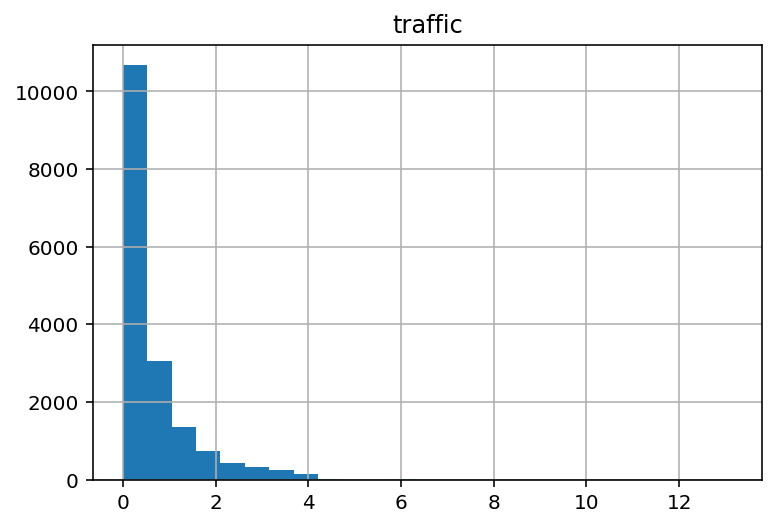

In [186]:
ds = df[(df['linea']==1) | (df['linea']==2)].sample(10**5).copy()

ds['datetime'  ] = ds['time'  ] + ' ' + ds['date']
ds['datetime_p'] = ds['time_p'] + ' ' + ds['date']

ds['date'      ] = pd.to_datetime(ds['date'      ])
ds['datetime'  ] = pd.to_datetime(ds['datetime'  ])
ds['datetime_p'] = pd.to_datetime(ds['datetime_p'])

ds['weekday'] = ds['date'].dt.weekday # Lunedì = 0
ds['weekend'] = np.where(ds['weekday']<5,0,1)

# 1) Compute travel time
ds['dur_p'] = ds.groupby(['corsa', 'date'])['datetime_p'].shift()
ds['dur_p'] = (ds['datetime_p']-ds['dur_p']).fillna(0).astype(int)/10**9/60 # in minutes

ds['dur'  ] = ds.groupby(['corsa', 'date'])['datetime'].shift()
ds['dur'  ] = (ds['datetime']-ds['dur']).fillna(0).astype(int)/10**9/60 # in minutes

# Remove events when the bus is stopped
ds = ds[ds['dur']>0 ]

# Remove huge outliers
ds = ds[ds['dur']<20]

# 2) Collapse across lines and days and compute sensitivity to traffic
dz = ds.groupby(['indirizzo','weekend','hour'])[['dur', 'dur_p']].mean()

minima = dz['dur'].unstack(level=2).min(axis=1)
maxima = dz['dur'].unstack(level=2).max(axis=1)
sensitivity = maxima / minima

# 3) Collapse across lines
dz = ds.groupby(['indirizzo','weekend','date', 'hour'])[['dur', 'dur_p']].mean()

# 4) Compute `benchmark` travel time (median across days of the minimum across hours and lines)
minima_2 = dz.groupby(['indirizzo','date'])[['dur', 'dur_p']].min()
minima_3 = minima_2.groupby(['indirizzo'])[['dur', 'dur_p']].median()

# 5) Compute Traffic Metric
dz = dz.reset_index().set_index('indirizzo')
dz['benchmark'  ] = minima_3['dur'  ]
dz['benchmark_p'] = minima_3['dur_p']
dz = dz.reset_index().set_index(['indirizzo', 'weekend', 'date', 'hour'])
dz['traffic'  ] = np.maximum(dz['dur'  ] / dz['benchmark'  ] - 1, 0)
dz['traffic_p'] = np.maximum(dz['dur_p'] / dz['benchmark_p'] - 1, 0)

# Plot
dz[['traffic']].hist(bins=25);

In [187]:
len(df)/10**5

75.45251

In [208]:
res = pd.read_parquet("traffic.parquet")

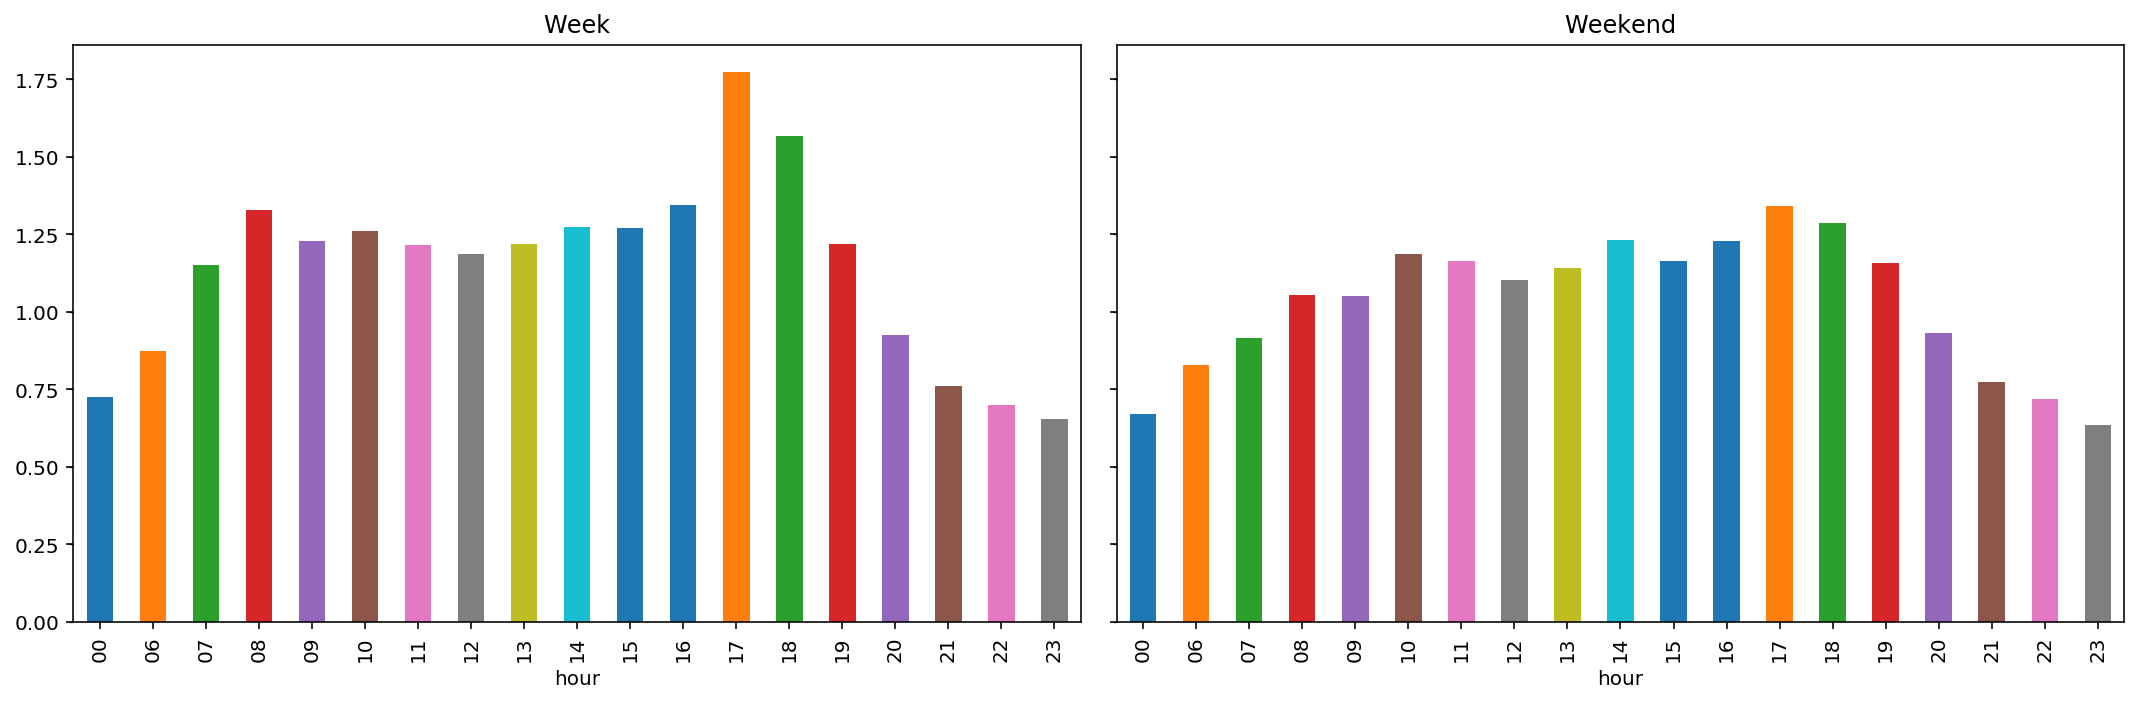

In [149]:
#ds = ds[ds['indirizzo']=='Paradiso- Riva Paradiso- Mast 1']

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5),sharey=True)
te = ds.xs(0,level=1)

te = te['dur'].unstack(level=1).mean()
te.plot(kind='bar',ax=ax1);

te = ds.xs(1,level=1)
te = te['dur'].unstack(level=1).mean()

te.plot(kind='bar',ax=ax2);

ax1.set_title("Week")
ax2.set_title("Weekend")
plt.tight_layout();

In [225]:
te.to_frame()

,0
hour,
06,1.933333
07,2.198148
08,2.088889
09,3.163333
10,3.744444
11,2.611111
12,3.328889
13,2.366667
14,2.686667


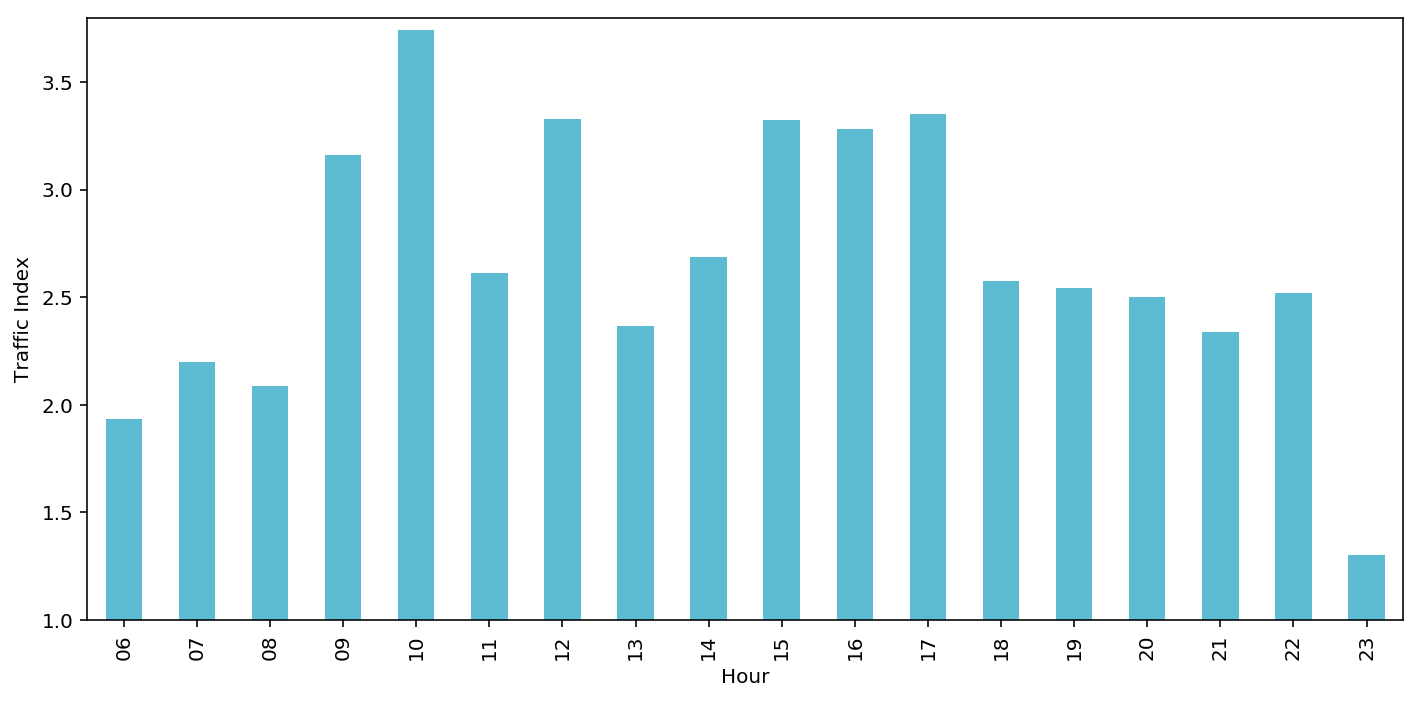

In [252]:
dz = ds[ds['dur'  ]<20]

dz = dz[dz['indirizzo']=='Paradiso- Debarcadero- Mast 1']
dz = dz[dz['dur_p']<20]
dz = dz[dz['dur_p']>0 ]
dz = dz.groupby(['indirizzo','weekend','hour'])[['dur', 'dur_p']].mean()

fig, ax1 = plt.subplots(1,1, figsize=(10,5),sharey=True)
te = dz.xs(0,level=1)

te = te['dur'].unstack(level=1).mean()
te.plot(kind='bar',ax=ax1, color='#5DBCD2', alpha=1, label='');

#te = dz.xs(1,level=1)
#te = te['dur'].unstack(level=1).mean()

#te.plot(kind='bar',ax=ax2);
ax1.set_title("")
#ax2.set_title("Weekend")
plt.tight_layout();
ax1.set_title("")
ax1.xaxis.set_label_text("Hour");
ax1.yaxis.set_label_text("Traffic Index");
#ax1.legend(frameon=True);
ax1.set_ylim([1,3.8]);
plt.tight_layout();
plt.savefig("hours.pdf");

In [253]:
!open .

In [124]:
len(ds[ds['linea']=='S'])

6896

In [150]:
ds['indirizzo'].unique()

array(['Pazzallo- P&R Fornaci- Mast 1', 'Paradiso- Carzo- Mast 1',
       'Paradiso- Brentino- Mast 2', 'Paradiso- Geretta- Mast 2',
       'Paradiso- Fontana- Mast 2', 'Paradiso- Debarcadero- Mast 2',
       'Lugano- Malpensata- Mast 2', 'Lugano- Piazza Luini- Mast 2',
       'Lugano- Piazza Rezzonico- Mast 2',
       'Lugano- Piazza Manzoni- Mast 2', 'Lugano- Centro- Mast 5',
       'Lugano- Piazza Manzoni- Mast 1',
       'Lugano- Piazza Rezzonico- Mast 1', 'Lugano- Piazza Luini- Mast 1',
       'Lugano- Malpensata- Mast 1', 'Paradiso- Debarcadero- Mast 1',
       'Paradiso- Riva Paradiso- Mast 1',
       'Paradiso- Stazione / Scuole- Mast 1',
       'Paradiso- Stazione- Mast 1', 'Paradiso- Via Calprino- Mast 1',
       'Paradiso- la Sguancia- Mast 1', "TPL Rimessa Rugi' A",
       "TPL Rimessa Rugi' E"], dtype=object)